In [2]:
#!pip install --upgrade tensorflow 

In [3]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [4]:
# Lets import all required libraries

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence  import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,SpatialDropout1D,Dropout,Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
import os

In [6]:
#importing data
train=pd.read_excel(r'E:Hackathon/MachineHack/News_Category_prediction/Data/Participants_Data_News_category/Data_Train.xlsx')

In [7]:
test=pd.read_excel(r'E:Hackathon/MachineHack/News_Category_prediction/Data/Participants_Data_News_category/Data_Test.xlsx')

In [8]:
sub_file=pd.read_excel(r'E:Hackathon/MachineHack/News_Category_prediction/Data/Participants_Data_News_category/Sample_submission.xlsx')

In [9]:
train.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


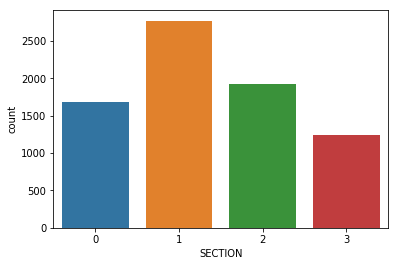

In [10]:
sns.countplot('SECTION',data=train)

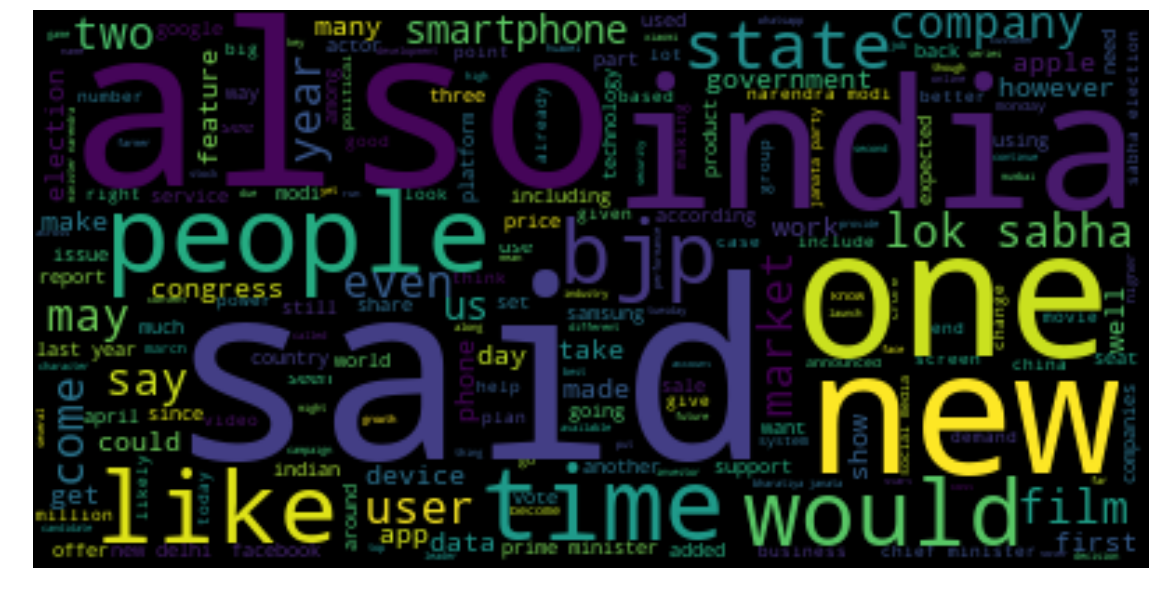

In [11]:
stop_words=stopwords.words('english')
text=''.join(train['STORY'].str.lower())
cloud=WordCloud(random_state=21,stopwords=stop_words).generate(text)
plt.figure(figsize=(20,20))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
text=''.join(train['STORY'].str.lower())
text=re.sub('[^a-z]',' ',text)
words=[word for word in text.split() if word not in stop_words]
freq=nltk.FreqDist(words)
freq_df=pd.DataFrame({'WORDS':list(freq.keys()),'COUNT':list(freq.values())})
freq_df.head()

,WORDS,COUNT
0,painful,8
1,huge,130
2,reversal,7
3,fee,28
4,income,200


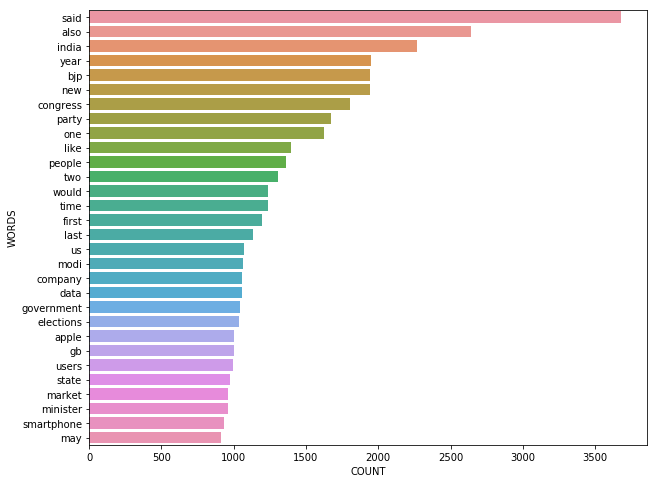

In [13]:
plt.figure(figsize = (10,8))
top_n = freq_df.nlargest(30,columns='COUNT')
sns.barplot(data = top_n,x = 'COUNT',y = 'WORDS')

# Text Preprocessing

In [14]:
def Clean_Text(data,column):
    data=data[column].str.lower()
    #We will remove the most repeated words like 'said','us','also'
    data=data.str.replace('said','')
    data=data.str.replace('also','')
    data=data.str.replace('us','')
    data=data.apply(lambda x: re.sub(r'[^a-z]',' ',x))#Remove numbers, special characters
    data = data.apply(lambda x : ' '.join([word for word in nltk.word_tokenize(x) if word not in stop_words]))#Stop word removal
    data = data.apply(lambda x : ' '.join([word for word in x.split() if len(word) > 2 ]))
    return data
    

In [15]:
train['clean']=Clean_Text(train,'STORY')

In [16]:
train.head()

,STORY,SECTION,clean
0,But the most painful was the huge reversal in ...,3,painful huge reversal fee income unheard among...
1,How formidable is the opposition alliance amon...,0,formidable opposition alliance among congress ...
2,Most Asian currencies were trading lower today...,3,asian currencies trading lower today south kor...
3,"If you want to answer any question, click on ‘...",1,want answer question click answer clicking ans...
4,"In global markets, gold prices edged up today ...",3,global markets gold prices edged today disappo...


# using glove embedding

In [17]:

xtrain,xvalid,ytrain,yvalid=train_test_split(train['clean'].values,train['SECTION'],stratify=train['SECTION'],random_state=20,
                                            test_size=0.1,shuffle=True)

In [18]:
EMBEDDING_FILE = 'E:/glove.6B/glove.6B.300d.txt'
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE,encoding='utf8'))

In [19]:
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [20]:
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())


In [21]:
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]


100%|██████████| 763/763 [00:00<00:00, 1142.45it/s]


In [22]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)


In [23]:
yvalid_enc = keras.utils.to_categorical(yvalid)
ytrain_enc = keras.utils.to_categorical(ytrain)


In [24]:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [25]:
token = Tokenizer(num_words=None)
max_len = 100

In [26]:
token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

In [27]:
# zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

In [28]:
word_index = token.word_index

In [29]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 30460/30460 [00:00<00:00, 169266.78it/s]


In [30]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])


In [31]:
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=20, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 1.3844 - acc: 0.271 - ETA: 3:25 - loss: 1.3298 - acc: 0.329 - ETA: 2:42 - loss: 1.3012 - acc: 0.339 - ETA: 2:13 - loss: 1.2467 - acc: 0.392 - ETA: 1:52 - loss: 1.1871 - acc: 0.452 - ETA: 1:35 - loss: 1.1139 - acc: 0.506 - ETA: 1:20 - loss: 1.0231 - acc: 0.556 - ETA: 1:06 - loss: 0.9445 - acc: 0.595 - ETA: 54s - loss: 0.8855 - acc: 0.625 - ETA: 42s - loss: 0.8250 - acc: 0.65 - ETA: 31s - loss: 0.7982 - acc: 0.67 - ETA: 20s - loss: 0.7695 - acc: 0.69 - ETA: 10s - loss: 0.7445 - acc: 0.71 - ETA: 0s - loss: 0.7293 - acc: 0.7225 - 156s 11s/step - loss: 0.7293 - acc: 0.7225 - val_loss: 0.2628 - val_acc: 0.9450
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 0.3066 - acc: 0.931 - ETA: 53s - loss: 0.2875 - acc: 0.92 - ETA: 1:04 - loss: 0.2871 - acc: 0.926 - ETA: 1:06 - loss: 0.2726 - acc: 0.926 - ETA: 1:05 - loss: 0.2704 - acc: 0.924 - ETA: 1:00 - loss: 0.2611 - acc: 0.926 - ETA: 55s - loss: 0.2645 - acc: 0

14/14 [==============================] - ETA: 0s - loss: 0.1504 - acc: 0.941 - ETA: 1:03 - loss: 0.1240 - acc: 0.954 - ETA: 1:17 - loss: 0.1152 - acc: 0.960 - ETA: 1:19 - loss: 0.1143 - acc: 0.957 - ETA: 1:15 - loss: 0.1129 - acc: 0.958 - ETA: 1:10 - loss: 0.1066 - acc: 0.959 - ETA: 1:03 - loss: 0.1045 - acc: 0.960 - ETA: 55s - loss: 0.1004 - acc: 0.962 - ETA: 47s - loss: 0.1035 - acc: 0.96 - ETA: 38s - loss: 0.1098 - acc: 0.96 - ETA: 28s - loss: 0.1130 - acc: 0.96 - ETA: 19s - loss: 0.1101 - acc: 0.96 - ETA: 9s - loss: 0.1087 - acc: 0.9627 - ETA: 0s - loss: 0.1081 - acc: 0.963 - 135s 10s/step - loss: 0.1081 - acc: 0.9631 - val_loss: 0.1018 - val_acc: 0.9685
Epoch 14/20
14/14 [==============================] - ETA: 0s - loss: 0.1031 - acc: 0.968 - ETA: 1:04 - loss: 0.0890 - acc: 0.972 - ETA: 1:19 - loss: 0.0992 - acc: 0.965 - ETA: 1:20 - loss: 0.1009 - acc: 0.963 - ETA: 1:17 - loss: 0.0991 - acc: 0.965 - ETA: 1:12 - loss: 0.0944 - acc: 0.966 - ETA: 1:04 - loss: 0.1022 - acc: 0.964 - ET

In [32]:
seq = token.texts_to_sequences(test['STORY'])
padded = pad_sequences(seq, maxlen=100)
pred=model.predict_classes(padded)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [33]:
submission = pd.DataFrame({'SECTION':pred})
submission.to_excel('submission2.xlsx', index=False)